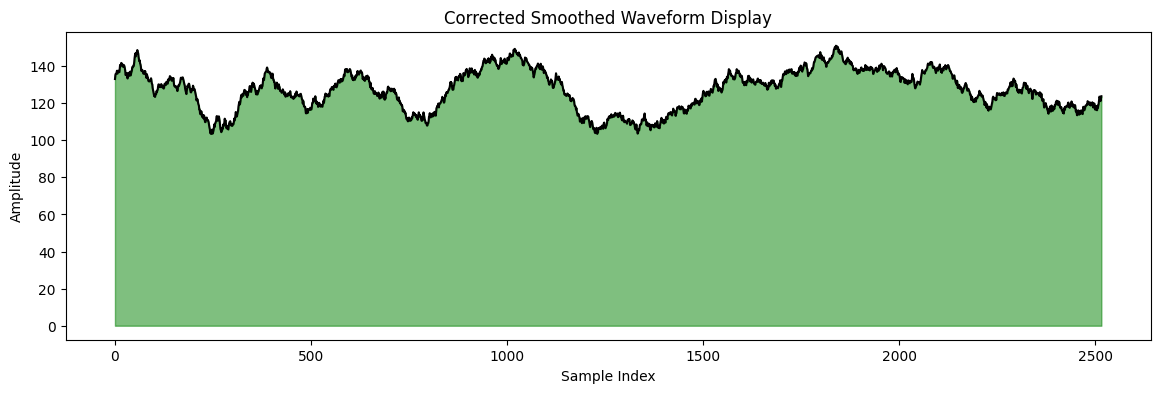

In [24]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd

def get_third_track(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    # Modify the query to skip the first two rows and get the third one
    query = "SELECT * FROM Track LIMIT 1 OFFSET 2;"
    cursor.execute(query)
    row = cursor.fetchone()
    column_names = [description[0] for description in cursor.description]
    
    df = pd.DataFrame([row], columns=column_names)
    print(column_names)
    conn.close()
    return df


def decode_binary_data(binary_data, dtype=np.uint8):
    print("Raw binary data (first 64 bytes):", binary_data[:64])
    element_size = np.dtype(dtype).itemsize
    if len(binary_data) % element_size != 0:
        binary_data = binary_data[:-(len(binary_data) % element_size)]
    decoded_data = np.frombuffer(binary_data, dtype=dtype)
    print(f"Decoded data ({dtype}) (first 10 values):", decoded_data[:10])
    return decoded_data

def calculate_dynamic_range(waveform_data):
    return np.max(waveform_data) - np.min(waveform_data)

def segment_phases_by_beats(waveform_data, beat_data, beats_per_phase):
    total_beats = len(beat_data)
    num_phases = total_beats // beats_per_phase
    features_by_phase = []

    for i in range(num_phases):
        start = i * beats_per_phase
        end = start + beats_per_phase
        segment_waveform = waveform_data[start:end]
        segment_beats = beat_data[start:end] if beat_data is not None else None

        phase_features = {
            'waveform_mean': np.mean(segment_waveform),
            'waveform_var': np.var(segment_waveform),
            'waveform_peaks': np.count_nonzero((segment_waveform[1:] > 0) & (segment_waveform[:-1] <= 0)),
            'beat_mean': np.mean(segment_beats) if segment_beats is not None else None,
            'beat_var': np.var(segment_beats) if segment_beats is not None else None,
            'beat_density': np.count_nonzero(segment_beats) / len(segment_beats) if segment_beats is not None else None
        }

        features_by_phase.append(phase_features)

    return features_by_phase

def extract_features_from_db(track_data, beats_per_phase=32):
    try:
        bpm = track_data.get('bpmAnalyzed', track_data.get('bpm', None))
        length = track_data.get('length', None)
        energy = track_data.get('energy', None)
        
        waveform_data = decode_binary_data(track_data['overviewWaveFormData'], dtype=np.uint8) if 'overviewWaveFormData' in track_data else None
        beat_data = decode_binary_data(track_data['beatData'], dtype=np.uint8) if 'beatData' in track_data else None

        features = {
            'bpm': bpm,
            'length': length,
            'energy': energy,
            'waveform_mean': np.mean(waveform_data) if waveform_data is not None else None,
            'waveform_var': np.var(waveform_data) if waveform_data is not None else None,
            'dynamic_range': calculate_dynamic_range(waveform_data) if waveform_data is not None else None,
        }

        if waveform_data is not None and beat_data is not None:
            phases_features = segment_phases_by_beats(waveform_data, beat_data, beats_per_phase)
            for i, phase in enumerate(phases_features):
                for key, value in phase.items():
                    features[f'phase_{i+1}_{key}'] = value

        return features

    except Exception as e:
        print(f"Error encountered while extracting features: {e}")
        return None

def detect_phase_boundaries(waveform_data, beat_data, segment_length_in_beats=32):
    segment_length = segment_length_in_beats
    num_segments = len(beat_data) // segment_length
    phase_boundaries = []

    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length
        segment_waveform = waveform_data[start:end]
        segment_beats = beat_data[start:end]

        energy_change = np.var(segment_waveform)
        beat_pattern_change = np.var(segment_beats)
        
        if energy_change > 1000 or beat_pattern_change > 500:  # Adjusted thresholds
            phase_boundaries.append(start)

    return phase_boundaries

import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

def get_third_track(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Track LIMIT 1 OFFSET 2;"
    cursor.execute(query)
    row = cursor.fetchone()
    column_names = [description[0] for description in cursor.description]
    df = pd.DataFrame([row], columns=column_names)
    conn.close()
    return df

def decode_waveform_data(binary_data, dtype=np.uint8):
    """Decode waveform data from binary to numpy array and normalize it."""
    decoded_data = np.frombuffer(binary_data, dtype=dtype)
    return decoded_data

def smooth_waveform(waveform_data, window_size=100):
    """Smooth the waveform data by averaging over a sliding window."""
    smoothed_data = np.convolve(waveform_data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data

def plot_waveform(waveform_data, title="Smoothed Waveform"):
    """Plot the smoothed waveform data."""
    smoothed_data = smooth_waveform(waveform_data)
    plt.figure(figsize=(14, 4))
    plt.plot(smoothed_data, color='black')
    plt.fill_between(range(len(smoothed_data)), smoothed_data, color='green', alpha=0.5)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()

# Main execution
db_path = "/Users/beenerdy/Music/Engine Library/Database2/hm.db"  # Replace with your .db file path

# Get the third track data
track_data = get_third_track(db_path)

# Decode the waveform data
waveform_data = decode_waveform_data(track_data.iloc[0]['overviewWaveFormData'], dtype=np.uint8)

# Plot the smoothed waveform
plot_waveform(waveform_data, title="Corrected Smoothed Waveform Display")
